# 🛠️ MLflow Hands-On

🎯 **Our goal** is to demonstrate how to integrate **MLflow** into a *machine learning* project, showcasing its role in tracking and managing experiments efficiently.

We'll start by **fitting an initial boosting model**, logging parameters, metrics, and artifacts. Then, we'll move on to **hyperparameter optimization using Optuna**, with the entire workflow tracked and versioned through MLflow.

---------------

🛒 **Dataset**
For this project, we used the **Wholesale Customers Data Set**, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers).

This dataset provides insights into customer spending habits across different product categories, making it a useful resource for unsupervised learning and clustering tasks.

In [1]:
# ===========================
# 📦 Data Manipulation
# ===========================
import os
import json
import math
import tempfile
import shutil
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

# ===========================
# 📊 Visualization
# ===========================
import matplotlib.pyplot as plt
import seaborn as sns


# ===========================
# 🤖 Modeling and Evaluation
# ===========================
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, log_loss, confusion_matrix, 
    ConfusionMatrixDisplay, mean_squared_error)

# ===========================
# 🔍 Optimization & Tracking
# ===========================
import optuna
import mlflow
import sys
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient

# ===========================
# 🛠️ Utilities
# ===========================
import warnings
warnings.filterwarnings('ignore')


## 📥 Import dataset

In [2]:
df = pd.read_csv('Wholesale customers data.csv')
df.tail()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125
439,1,3,2787,1698,2510,65,477,52


## 🔍 Checking for missing values

In [3]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

## 🎯 Declare feature vector and target variable

In [4]:
X = df.drop('Channel', axis=1)
# ---
y = df['Channel']
y.head()

0    2
1    2
2    2
3    1
4    2
Name: Channel, dtype: int64

We can see that the \$y\$ labels currently contain the values \$1\$ and \$2\$. For simplicity and easier interpretation, we will convert them to \$0\$ and \$1\$ for further analysis.

In [5]:
y[y == 2] = 0
y[y == 1] = 1

Now, I will convert the dataset into an optimized data structure called **Dmatrix** that XGBoost supports and gives it acclaimed performance and efficiency gains

In [6]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

## ✂️ Split data into separate training and test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## 🔧 Train the XGBoost Classifier

Now it's time to train our **XGBoost classifier**!
Before we begin, it’s important to understand the different types of parameters that XGBoost offers. These parameters control the model’s behavior, performance, and complexity.

There are **four main categories** of parameters you should know:


### ⚙️ General parameters

These define which **booster type** to use (e.g., tree-based or linear).
Common options include:

* `gbtree` – tree-based models (default)
* `gblinear` – linear models
* `dart` – tree-based models with dropout


### 🌲 Booster parameters

These depend on the selected booster type and control the training process of individual trees or models.


### 🎯 Learning task parameters

These define the **objective function** and the type of learning task (e.g., regression, classification, ranking).

### 💻 Command line parameters

These relate to the CLI (Command Line Interface) version of XGBoost, and aren’t usually needed when using the Python API.


## 🧠 Key Parameters to know

Here are some of the most important parameters you'll likely tune:

* **`learning_rate`** – Controls the step size shrinkage to prevent overfitting. Range: `[0, 1]`.
* **`max_depth`** – Maximum depth of a tree. Deeper trees can capture more complex patterns.
* **`subsample`** – Fraction of the training data to use for each tree. Lower values can help prevent overfitting.
* **`colsample_bytree`** – Fraction of features to use for each tree. Higher values may lead to overfitting.
* **`n_estimators`** – Number of boosting rounds (i.e., trees).
* **`objective`** – Specifies the learning task and the corresponding loss function:

  * `reg:squarederror` – for regression
  * `binary:logistic` – for binary classification (probability output)
  * `reg:logistic` – for classification with decision outputs


## 🛡️ Regularization parameters

XGBoost also offers regularization to reduce model complexity and avoid overfitting:

* **`gamma`** – Minimum loss reduction required to make a split. Higher values result in fewer splits.
* **`alpha`** – L1 regularization term on weights (Lasso). Encourages sparsity.
* **`lambda`** – L2 regularization term on weights (Ridge). Adds smoothness.

Even though we're using **trees as base learners**, XGBoost also supports linear models (`gblinear`) and dropout-based trees (`dart`) via the `booster` parameter.

---

Imagine you're a data scientist, and it's time to fine-tune your machine learning model. Fortunately, after some experimentation, you’ve found that the parameter combination below delivers a satisfactory performance for your classification task.


In [9]:
params = {
    # Target function for binary classification
    'objective': 'binary:logistic',

    # Evaluation metric
    'eval_metric': 'logloss',

    # Booster type (default is 'gbtree')
    'booster': 'gbtree',

    # Learning rate (step size shrinkage)
    'learning_rate': 0.1,

    # Maximum depth of each tree
    'max_depth': 3,

    # Subsample ratio of the training instances
    'subsample': 0.8,

    # Subsample ratio of columns for each tree
    'colsample_bytree': 0.8,

    # L2 regularization term on weights (Ridge)
    'lambda': 1.0,

    # L1 regularization term on weights (Lasso)
    'alpha': 0.0}

#------------------

# Instantiate the classifier
xgb_clf = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
print(xgb_clf)


XGBClassifier(alpha=0.0, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1.0,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)


## 🔮 Make Predictions with XGBoost Classifier

In [10]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

## ✅ Check Accuracy Score

Accuracy:  0.8939
Precision: 0.8913
Recall:    0.9535
f1-Score:  0.9213
AUC:       0.9626


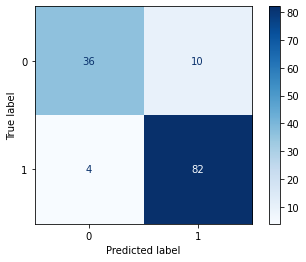

In [11]:
# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])

# Print scores
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'f1-Score:  {f1:.4f}')
print(f'AUC:       {auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## 🔍 Feature importance with XGBoost

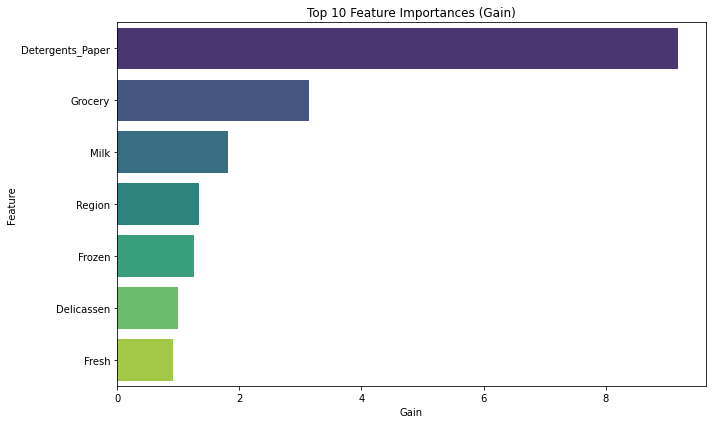

In [12]:
importances = xgb_clf.get_booster().get_score(importance_type='gain')

# Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
}).sort_values(by='Importance', ascending=False)

# Optional: show only top N features
top_n = 10
importance_df = importance_df.head(top_n)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title(f"Top {top_n} Feature Importances (Gain)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


------------

📦 **Project Handoff to MLOps**

Now, imagine this is the final output of a data scientist's work. This project will be handed over to a machine learning engineer, who will be responsible for versioning the model using MLflow.

The engineer will set up experiment tracking, store the generated artifacts, monitor model performance metrics, and ensure the entire workflow is reproducible all as part of a well-structured MLOps pipeline.

🎯 **Next Step: Hyperparameter Optimization**

From this point on, we will perform hyperparameter optimization using Optuna. Meanwhile, MLflow will continue to log each experiment, allowing us to compare versions and easily identify the best set of parameters.


---------

## ⚙️ MLOps in Practice: Managing the Machine Learning Model Lifecycle

Now, we explore how **MLOps** practices help structure, automate, and scale the machine learning model lifecycle — from data preparation and model training to deployment, monitoring, and continuous improvement. We'll demonstrate how tools like **MLflow** can streamline this process and ensure reproducibility, traceability, and collaboration across teams.

## 🚀 Initializing the MLflow Server

To start the MLflow tracking server locally, follow the steps based on your environment:

---

### 🐍 **Using Anaconda**

1. Open the **Anaconda Command Prompt**  
2. Navigate to your project directory:

   ```bash
   cd your-project-path

3. Run the MLflow server:

   ```bash
   python -m mlflow server --host 127.0.0.1 --port 8282


### 💻 **Using VS Code**

1. Open the **terminal** in VS Code
2. Run the command below:

   ```bash
   py -m mlflow server --host 127.0.0.1 --port 8282

✅ Make sure you're using the same Python environment or kernel as the one used in your notebook or training script.

-----

🛰️  Now, let's define the address of the MLflow tracking server — that is, where the experiment logs (parameters, metrics, models, etc.) will be sent and stored.

In [13]:
mlflow.set_tracking_uri('http://127.0.0.1:8282')

Access the URL above from a new tab in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 📈 **Monitoring the Trained Model**

To properly monitor the performance of the trained model, we will generate a series of visualizations that will help us better understand how the model is behaving.

These plots will assist in:

* Evaluating predictive quality
* Identifying potential bias or imbalance
* Detecting signs of overfitting or underfitting
* Supporting model explainability and transparency

By visualizing key metrics and outputs, we can gain valuable insights that go beyond raw numbers and ensure the model remains reliable over time.

In [14]:
def plot_corr(df, target='Channel', save_path=None, top_n=None):
    '''
    Parameters:
    - df: pandas DataFrame containing the dataset
    - target: string, name of the target column
    - save_path: optional path to save the figure (as PNG)
    - top_n: optional, number of top features to display based on absolute correlation
    '''
    # Compute correlations with the target 
    corr = df.corr()[target].drop(target)
    corr = corr.reindex(corr.abs().sort_values().index)

    # Optionally show only top N correlated features
    if top_n:
        corr = corr.tail(top_n)

    # Set clean white style
    sns.set_style('white')
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(corr) + 1))

    # Plot horizontal bars with elegant color
    bars = ax.barh(
        corr.index, corr.values,
        color='#4C72B0', edgecolor='black', height=0.6
    )

    # Add correlation values next to bars
    for bar in bars:
        width = bar.get_width()
        ax.text(
            x=width + 0.02 if width > 0 else width - 0.02,
            y=bar.get_y() + bar.get_height() / 2,
            s=f"{width:.2f}",
            va='center',
            ha='left' if width > 0 else 'right',
            fontsize=11)

    # Clean and minimal axes
    ax.set_title(f"Correlation with '{target}'", fontsize=16, pad=12)
    ax.set_xlabel("Correlation Coefficient", fontsize=13)
    ax.set_ylabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    # Save figure if needed
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.close(fig)
    return fig


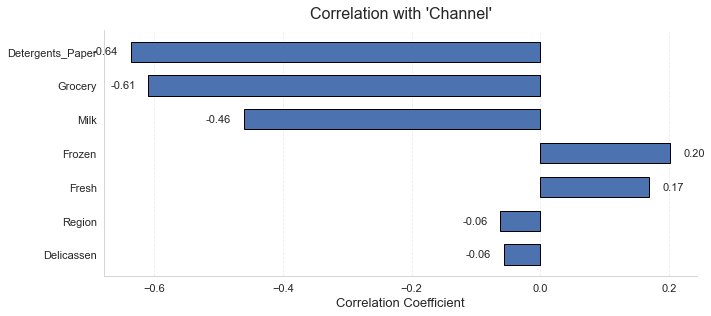

In [15]:
plot_corr(df)

In [16]:
def plot_confusion_matrix(y_true, y_pred, labels=None, save_path=None):
    '''
    Plots a styled confusion matrix with annotated counts.

    Parameters:
    - y_true: array-like, true target labels
    - y_pred: array-like, predicted labels
    - labels: optional list of label names (for axis ticks)
    - save_path: optional path to save the figure as PNG
    '''
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set seaborn style
    sns.set_style('whitegrid', {
        'axes.facecolor': '#eaeaf2',
        'grid.linewidth': 1.2})

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        cbar=False, square=True, linewidths=0.5,
        xticklabels=labels if labels else 'auto',
        yticklabels=labels if labels else 'auto',
        ax=ax)

    # Titles and labels
    ax.set_title('Confusion Matrix', fontsize=16, pad=12)
    ax.set_xlabel('Predicted Labels', fontsize=13)
    ax.set_ylabel('True Labels', fontsize=13)
    ax.tick_params(axis='both', labelsize=12)

    # Adjust layout
    plt.tight_layout()

    # ✅ Save if path provided
    if save_path:
        fig.savefig(save_path, format="png", dpi=600, bbox_inches='tight')

    # Close and return
    plt.close(fig)
    return fig


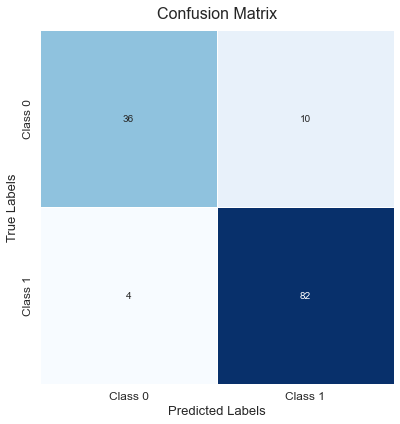

In [17]:
plot_confusion_matrix(y_test, y_pred, labels=['Class 0', 'Class 1'])

In [18]:
def plot_feature_importance(model, booster='gbtree', top_n=10, importance_type=None, save_path=None):
    '''
    Plots feature importance for a trained XGBoost model (either Booster or XGBClassifier).
    '''
    if importance_type is None:
        importance_type = 'weight' if booster == 'gblinear' else 'gain'

    # Handle both Booster and XGBClassifier
    if hasattr(model, 'get_booster'):
        booster_model = model.get_booster()
    else:
        booster_model = model  # assume it's already a Booster

    # Extract feature importances
    importances = booster_model.get_score(importance_type=importance_type)

    importance_df = pd.DataFrame({
        'Feature': list(importances.keys()),
        'Importance': list(importances.values())
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    sns.set_style('white')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')

    plt.title(f'Top {top_n} Feature Importances ({importance_type.title()})', fontsize=14)
    plt.xlabel(importance_type.title(), fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')

    fig = plt.gcf()
    plt.close()
    return fig


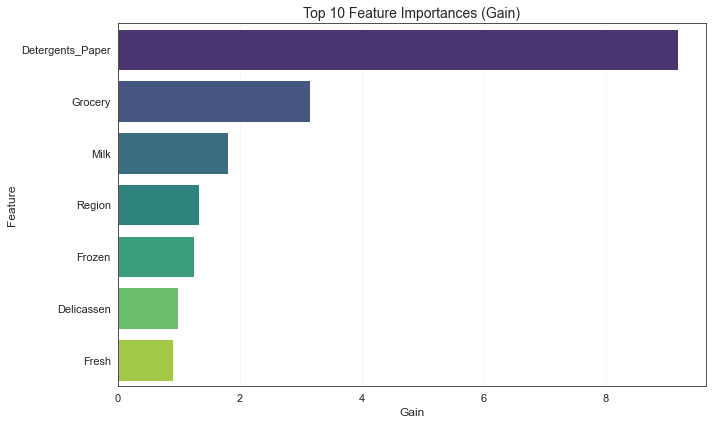

In [19]:
plot_feature_importance(xgb_clf, booster='gbtree', top_n=10, importance_type=None, save_path=None)

## 🧪 Creating the experiment in MLflow

In [20]:
# Function to create an MLflow experiment
def create_experiment(experiment_name):
    '''
    Creates an MLflow experiment if it doesn't already exist.
    
    Parameters:
    - experiment_name: string, name of the experiment to create or retrieve
    
    Returns:
    - experiment_id: the ID of the existing or newly created experiment
    '''

    # Check if the experiment already exists by name
    if experiment := mlflow.get_experiment_by_name(experiment_name):
        # If it exists, return its ID
        return experiment.experiment_id
    else:
        # If it doesn't exist, create a new one and return its ID
        return mlflow.create_experiment(experiment_name)

In [21]:
# creating the experiment
id_experiment = create_experiment('mlflow-project')
print(f'The ID of experiment is: {id_experiment}')

The ID of experiment is: 709956031418054632


View it in your browser: [http://127.0.0.1:8282](http://127.0.0.1:8282)


## 🛠️ Fine-tuning the model

🔍 Imagine your job is to monitor the performance of a model developed by **the data scientist**.\
🚀 Since you also have data science skills, you decide to take it a step further by optimizing the model’s **hyperparameters**.\
🧠 You know that, for the tuning to be meaningful and leakage-free, you must work with three separate datasets:
🏋️ The **training set** is used to adjust the model’s weights.\
🧪 The **validation set** helps you compare different hyperparameter configurations without touching the test set.\
🎯 The **test set** remains untouched until the final evaluation, ensuring that performance is measured on truly unseen data.\
✅ This setup ensures reliable, reproducible results and a model ready for production.


In [22]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fixed split into training and validation for all trials
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0)

🤖✨ **Why Use a Validation Set for Hyperparameter Tuning?** ✨🔍

When performing **hyperparameter tuning** (e.g., with Optuna), it's essential to split your data into three sets: **training**, **validation**, and **test**. Here’s why:

---

1. 🔒 **Avoid Information Leakage**

   * If you only use *train* and *test* and choose hyperparameters based on the *test* set, you're leaking information — meaning you've tuned for the *test* instead of truly measuring generalization.
   * 🛑 The **test** set must remain **untouched** until final evaluation, simulating truly unseen data.

2. 🎯 **Tune Using a Separate Set**

   * **Training set:** fits the model’s weights.
   * **Validation set:** compares different configurations (number of trees, depth, learning rate, etc.) without touching the *test* set.
   * ✅ Only after selecting the best configuration on the *validation* set should you “freeze” the model and evaluate it on the *test* set.

3. 🔄 **Reproducibility Across Trials**

   * By using the same *(X\_train, X\_valid)* split for **all** trials, you ensure that the only change Optuna sees is the **hyperparameter**, not a new data partition each time.
   * This makes comparisons between trials fairer and more stable.

4. 📊 **Typical Data Split**

   * `test_size=0.3` → 30% of the data is allocated to the **final test**.
   * Of the remaining 70%, using `test_size=0.2` gives 14% for **validation**, and 56% remains for **training**.
   * In summary:

     * 🏋️ **Training:** 56%
     * 🔎 **Validation:** 14%
     * 🎯 **Test:** 30%

---

### 🚀 Ideal Tuning Pipeline Flow

1. 🪓 **3-way split:** `train` ↔ `validation` ↔ `test`
2. ⚙️ **Hyperparameter optimization** using **train + validation**
3. 🏋️ **Final training** with the best configuration on **train + validation**
4. 🎯 **Final evaluation** on the **test** set (unseen data)

---

✅ **Benefits:**

* The model **doesn’t overfit** to the test set.
* Hyperparameter selection is **truly generalizable**.
* The final evaluation reflects the model’s **true performance** on new data.

You're now running a tuning process that’s leakage-proof and free from biased comparisons. 😉👍


## 🎯 Maximizing F1-Score for Balanced Performance


Here, we chose to **maximize the F1-score** as our objective in order to ensure a balanced and meaningful performance metric.


In [23]:
# Silence Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [24]:
def optimize_hyperparameters(trial):
    # Convert to DMatrix
    dsubtrain = xgb.DMatrix(X_train.values, label=y_train.values)
    dvalid   = xgb.DMatrix(X_valid.values, label=y_valid.values)

    # Hyperparameter search space
    params = {
        'objective':        'binary:logistic',
        'eval_metric':      'logloss',
        'booster':          trial.suggest_categorical('booster', ['gbtree','gblinear','dart']),
        'learning_rate':    trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda':       trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha':        trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)}

    # Each trial is a nested run in MLflow
    with mlflow.start_run(nested=True):
        model = xgb.train(
            params,
            dsubtrain,
            evals=[(dvalid, 'validation')],
            num_boost_round=1000,
            early_stopping_rounds=20,
            verbose_eval=False
        )

        # Evaluate on the validation set
        preds_proba = model.predict(dvalid)
        preds       = (preds_proba > 0.5).astype(int)
        f1          = f1_score(y_valid, preds)

        # Log parameters and metric to MLflow
        mlflow.log_params(params)
        mlflow.log_metric('f1_score', f1)

    # Optuna minimizes the objective, so return 1 - f1_score
    return 1.0 - f1

## 🏆 Tracking the Best F1-Score During Optimization

This callback monitors each trial and updates the current best F1-score. Whenever a new trial achieves a better score, it logs the result and stores it as the new winner, helping track progress in real time.


In [25]:
def f1_score_callback(study, frozen_trial):
    current_winner = study.user_attrs.get('winner', None)
    if study.best_value is not None and current_winner != study.best_value:
        study.set_user_attr('winner', study.best_value)
        print(f'New best F1-score: {1.0 - study.best_value:.4f} '
              f'on trial {frozen_trial.number}')

## 🧪 Full Training and Evaluation Pipeline with MLflow & Optuna

This script performs a complete machine learning workflow: it starts an MLflow run, optimizes hyperparameters with Optuna, logs the best trial's results, trains the final model using both training and validation data, and evaluates it on a held-out test set. Performance metrics (accuracy, precision, recall, F1-score) and the confusion matrix are logged. Finally, the model is saved with its signature for proper versioning in MLflow’s Model Registry.

In [26]:
run_name = 'experiment_1'
mlflow.set_experiment(experiment_id=id_experiment)

with mlflow.start_run(run_name=run_name):
    # Hyperparameter optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize_hyperparameters, n_trials=200, callbacks=[f1_score_callback])

    # Log best trial and F1-score as tags
    mlflow.set_tag('best_f1_score', f'{1.0 - study.best_value:.4f}')
    mlflow.set_tag('best_trial',    str(study.best_trial.number))

    # Final training using full train + validation data
    dtrainval = xgb.DMatrix(X_trainval.values, label=y_trainval.values)
    dtest     = xgb.DMatrix(X_test.values,      label=y_test.values)

    final_model = xgb.train(
        study.best_params,
        dtrainval,
        evals=[(dtest, 'test')],
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=False)

    # Evaluation on the test set
    y_pred_test   = final_model.predict(dtest)
    y_pred_binary = (y_pred_test >= 0.5).astype(int)

    acc  = accuracy_score(y_test, y_pred_binary)
    prec = precision_score(y_test, y_pred_binary)
    rec  = recall_score(y_test, y_pred_binary)
    f1   = f1_score(y_test, y_pred_binary)

    mlflow.log_metric('final_accuracy',  acc)
    mlflow.log_metric('final_precision', prec)
    mlflow.log_metric('final_recall',    rec)
    mlflow.log_metric('final_f1_score',  f1)

    # Confusion matrix 
    fig_path = os.path.join(tempfile.gettempdir(), 'confusion_matrix.png')
    plot_confusion_matrix(y_test, y_pred_binary, save_path=fig_path)
    mlflow.log_artifact(fig_path)

    # Correlation
    corr_path = os.path.join(tempfile.gettempdir(), 'correlation.png')
    plot_corr(df, target='Channel', save_path=corr_path)
    mlflow.log_artifact(corr_path)
    plt.close()

    # Feature importance
    fi_path = os.path.join(tempfile.gettempdir(), 'feature_importance.png')
    plot_feature_importance(
    model=final_model,
    booster="gbtree",
    top_n=10,
    importance_type=None,
    save_path=fi_path)
    mlflow.log_artifact(fi_path)
    plt.close()

    # Model signature inference for MLflow Model Registry
    signature = infer_signature(X_trainval, final_model.predict(dtrainval))

    # Save the final model
    tmp_dir         = tempfile.mkdtemp()
    model_save_path = os.path.join(tmp_dir, 'model')

    mlflow.xgboost.save_model(
        final_model,
        path=model_save_path,
        input_example=X_trainval.iloc[[0]],
        signature=signature,
        model_format='ubj',
        metadata={'model_data_version': 1})
    
    mlflow.log_artifacts(model_save_path, artifact_path='model')
    shutil.rmtree(tmp_dir)

print('-- Done --')

🏃 View run sedate-worm-457 at: http://127.0.0.1:8282/#/experiments/709956031418054632/runs/d6c484de6164459b85c39cdbf2bae836
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/709956031418054632
New best F1-score: 0.9487 on trial 0
🏃 View run learned-rook-368 at: http://127.0.0.1:8282/#/experiments/709956031418054632/runs/e45bd39f4d874605aa8334063cf139e3
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/709956031418054632
🏃 View run amusing-whale-268 at: http://127.0.0.1:8282/#/experiments/709956031418054632/runs/2488d853bce445e6b87f0eea6db1b442
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/709956031418054632
🏃 View run incongruous-calf-795 at: http://127.0.0.1:8282/#/experiments/709956031418054632/runs/f1bf63f5c8474c06be6a1245047aaf9f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/709956031418054632
🏃 View run legendary-goose-338 at: http://127.0.0.1:8282/#/experiments/709956031418054632/runs/19ba3a48cc5940ba99869a6b4aa48ba4
🧪 View experiment at: h

2025/07/21 11:03:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\VICTOR~1.FRA\AppData\Local\Temp\tmp8iqwr26i\model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 


🏃 View run experiment_1 at: http://127.0.0.1:8282/#/experiments/709956031418054632/runs/aee89910c8c24eacb3f1a9e556039d8f
🧪 View experiment at: http://127.0.0.1:8282/#/experiments/709956031418054632
-- Done --


## 🔚 All set! Now you have your experiment saved with the best trained model.
You can view the model, its metrics, artifacts, and parameters by visiting:
👉 http://127.0.0.1:8282 (open in a new browser tab)

📦 **Next step: using the trained model for inference**

Suppose you now want to use this final trained model to make predictions. For simplicity — and due to the lack of new data — we’ll reuse the same test set used earlier.

Just follow the steps below to load the model and make predictions:

In [27]:
client = MlflowClient()

# Filter the run by its exact name
papa = client.search_runs(
    experiment_ids=[id_experiment],
    filter_string='tag.mlflow.runName = "experiment_1"')[0]   

run_id_pai = papa.info.run_id
print("Parent RUN:", run_id_pai)
print("Base URI  :", papa.info.artifact_uri)

Parent RUN: aee89910c8c24eacb3f1a9e556039d8f
Base URI  : mlflow-artifacts:/709956031418054632/aee89910c8c24eacb3f1a9e556039d8f/artifacts


In [28]:
model_uri = f'runs:/{run_id_pai}/model'
model_uri_abs = f'{papa.info.artifact_uri}/model/'
model_uri_abs

'mlflow-artifacts:/709956031418054632/aee89910c8c24eacb3f1a9e556039d8f/artifacts/model/'

## 📦 Loading the Best Model



In [29]:
best_model = mlflow.xgboost.load_model(model_uri)

Accuracy  : 0.886
Precision : 0.890
Recall    : 0.942
F1-score  : 0.915


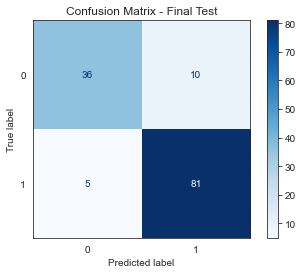

In [30]:
# Convert X_test to DMatrix
dtest = xgb.DMatrix(X_test)

# Make predictions (probabilities)
y_prob = best_model.predict(dtest)

# Apply 0.5 threshold to get binary classes
y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display the results
print(f'Accuracy  : {acc:.3f}')
print(f'Precision : {prec:.3f}')
print(f'Recall    : {rec:.3f}')
print(f'F1-score  : {f1:.3f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Final Test")
plt.show()


## 🏁 Conclusion 

As mentioned earlier, we reused the same test set **just to demonstrate** how to load the model from MLflow.
To verify whether this is truly the **best-performing final model**, simply go to your MLflow experiment, check the corresponding **run ID**, and compare the logged **metrics** with the ones printed above.
